# Part B: E4D Mesh Generation

This notebook is to generate **E4D Mesh Files**. Make sure you have finished **PartB_Kernel_Customize** and select **your own kernel** for this notebook. By running this notebook, users can **construct their own configuration files** or **use available configuration files** to **generate E4D mesh**.<br>
The E4D mesh domain should **contain PFLOTRAN mesh domain** and for higher computational accuracy, the PFLOTRAN Mesh domain should be refined as much as possible in E4D Mesh domain. So users need to provide the information of PFLOTRAN mesh, including **Coordinates of Base Point, Rotation Angle, and Domain Size**. A explanatory plot will be shown to explain what these parameters stands for.<br>
Brief introduction of the notebooks and tips will be included before or after the relevant cell in this notebook.<br> 
For more detailed information to construct or learn the E4D Configuration files, please read **T.C. Johnson's** (E4D Developer) tutorial: https://e4d.pnnl.gov/Documents/E4D_User_Guide.pdf. I also upload one copy in this folder.<br>
Please the workflow of **PartC**, **PartD** and **PartE**. **PartC** includes **Step 1: E4D Mesh Generation**; **PartD** includes **Step 2: Mesh Interpolation Matrix**. **PartE** includes from **Step 3: PFLOTRAN Simulation Time Extraction to Step 6: E4D Forward Simulation**.

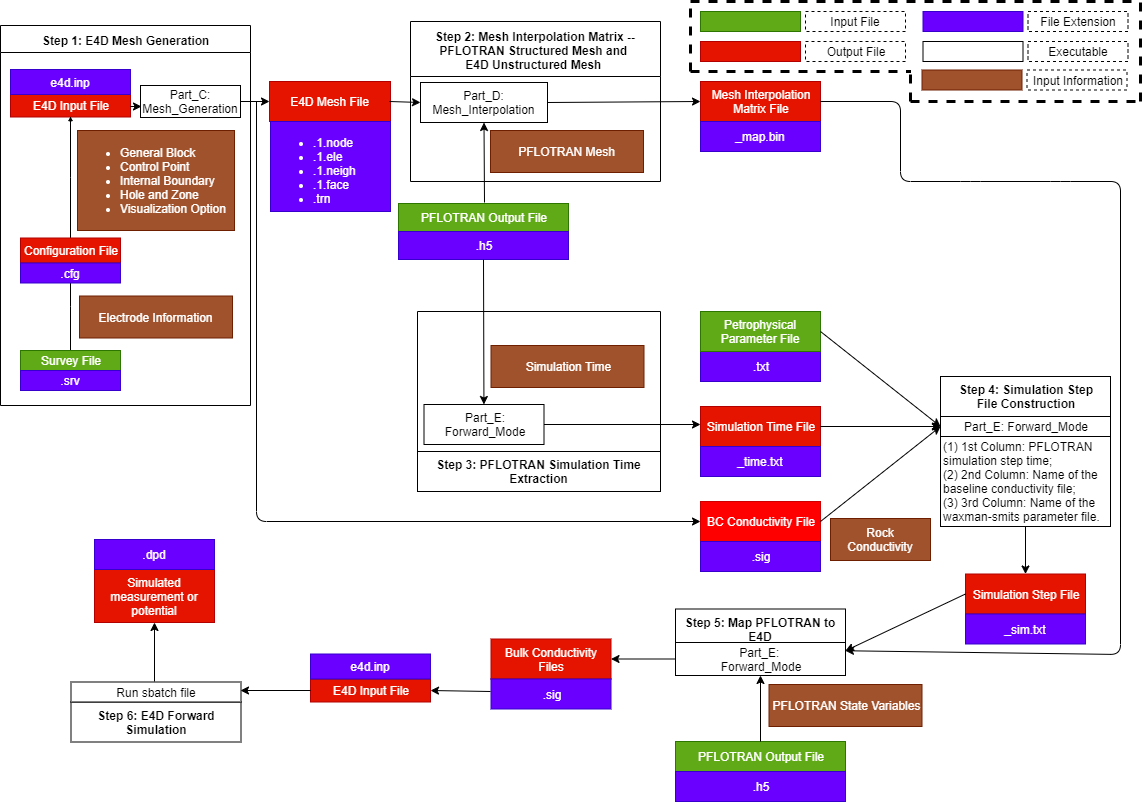

In [1]:
from IPython.display import Image
# from IPython.core.display import HTML 
Image(filename = 'Notebook_Picture/' + 'workflow_diagram.png', width=1000, height=1000)

# 1. Pre-processing

## 1.1 Modules Import

To run the notebook, you need the packages below:<br>
   * os
   * io
   * sys
   * math
   * IPyhon
   * imp
   * numpy
   * matplotlib
   * ipywidgets
   
This step will check if all the required libraries installed or not. Package 1 to 6 are the standard libraries, which should be installed automatically. So they are not checked. If any libraries missed, the commands will install the missed libraries.

In [2]:
# Check libraries installed or not. If not, install the missed libraries.

import imp

lib_req = ['os','io','sys','math','IPython','imp','numpy','matplotlib','ipywidgets']
lib_req_num = len(lib_req)

for i in range(lib_req_num):
    try:
        imp.find_module(lib_req[i])
    except ImportError:
        print(lib_req[i] + ' is not installed. Please use the relevant command below to install.')

Command to install missing packages. Delete '#' of the package you want to install.

In [3]:
#!pip install h5py --user
#!pip install matplotlib --user
#!pip install pyvista --user
#!pip install ipywidgets --user

<font color = red>Tips: The commands can only detect the libraries installed via **pip** and **conda**, which include most of the libraries installed. I will try other commands to include all libraries and update.<br>
The Python version for the kernel is Python3.6 and there are some updated packages in Python3.7, which means sometimes when you run '!pip install package_name --user', you can't install that because it exists in Python3.7 but you can't import it in Python3.7. The best way is to switch your Python to 3.7 in your **'kernel-helper.sh'**. However, Python3.7 will cause some problems, not very stable, so you can install the packages in the terminal after activating your kernel: <br>
    Open a terminal, and activate the selected kernel. Then use the command: **pip install package_name**<br>
    
After that, run **import package_name** again.<br><font>

In [4]:
import os
import io
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
import imp
import ipywidgets as widgets
from IPython.display import display

# Widgets style definition
style = {'description_width': '150px'}

## 1.2 Input Files Check

PartC needs some files as input:<br>
(1) If **E4D Configuration files** are available, jump to section 3 to call E4D to generate **E4D Mesh files**;<br>
(2) If **E4D Configuration files** are unavailable, construct E4D Configuration files, and users need to input the **prefix** as E4D Mesh file name.

In [5]:
# Get the path of current folder
path = os.getcwd()

# Detect the E4D Configuration files with extension '.cfg'
cfg_files = [f for f in os.listdir(path) if f.endswith('.cfg')]
cfg_files.append('New cfg File')

print('Please select E4D Configuration file: ')
cfg_files_options = widgets.RadioButtons(
    options= cfg_files,
    description='E4D cfg file:',
    disabled=False
)
display(cfg_files_options)

Please select E4D Configuration file: 


RadioButtons(description='E4D cfg file:', options=('E4D_Mesh_Example.cfg', 'E4D_Mesh_1.cfg', 'E4D_Mesh_1-zone1…

In [6]:
cfg_decision = cfg_files_options.value

if cfg_decision == 'New cfg File':
    prefix = input('Enter the prefix you want, characteristic and number preferred: ')
    print('The files generated in this workflow will be with the prefix: ', '\x1b[0;30;42m'+prefix+'\x1b[0m')
    cfg_file_name = prefix+'.cfg'
    
else:
    cfg_file_name = cfg_decision
    print('Please jump to section 3 to generate E4D Mesh Files.')
    
print('The cfg file name is ', '\x1b[0;30;42m'+cfg_file_name+'\x1b[0m')

Enter the prefix you want, characteristic and number preferred:  E4D_1


The files generated in this workflow will be with the prefix:  E4D_1
The cfg file name is  E4D_1.cfg


In [7]:
# Survey File check
srv_files = [f for f in os.listdir(path) if f.endswith('.srv')]
srv_l = len(srv_files)

if srv_l == 0:
    print('\x1b[0;30;41m' + 'Survey file' + '\x1b[0m', 'is not available, please upload a survey file.')
else:
    print ('\x1b[0;30;42m' + 'Survey File' + '\x1b[0m', 'has been found, please select:')
    srv_options = widgets.RadioButtons(
        options= srv_files,
        description='Survey File:',
        disabled=False
)
    display(srv_options)

Survey File has been found, please select:


RadioButtons(description='Survey File:', options=('10015200.srv', 'E4D_comp.srv'), value='10015200.srv')

# 2. E4D Mesh Generation

This section is to **construct or select available E4D Mesh files**. Before the E4D Mesh Generation, Let's talk about what **priniciples of the E4D Mesh generation** should be:<br>
1. To succeed coupling PFLOTRAN and E4D:<br>
  (1) Compute the **mesh interpolation matrix** to couple different mesh of **PFLOTRAN and E4D**;<br>
  (2) Map the **PFLOTRAN simulation results (Tracer, Saturation, Temperature, and Porosity)** from **PFLOTRAN Mesh to E4D Mesh** based on the **mesh interpolation matrix** from last step.<br>
  <font color=red> **So the E4D Mesh should be the same size with PFLOTRAN Mesh. If you have not run PFLOTRAN, it is better to design the mesh size which is good for both PFLOTRAN and E4D.** <font> <br>
  If you can't change PFLOTRAN Mesh, at lease your E4D Mesh should contain PFLOTRAN Mesh, but what the influence will cause...? I am testing some cases and will add my test results when I finish that... should be before next week.
    
2. For precise simulation results:<br> 
    <font color = red>**Maybe there are some important zones in your target region, such as the groundwater table variable zone, which is better to be set as an individual zone and more refined.** <font>
        
The above are two main priciples of designing E4D Mesh. Something detailed or limitated will be included in relevant steps. Please read the explanation of every steps to make sure everything can satisfy your requirement.

## 2.1 PFLOTRAN Mesh Domain Information Acquisition

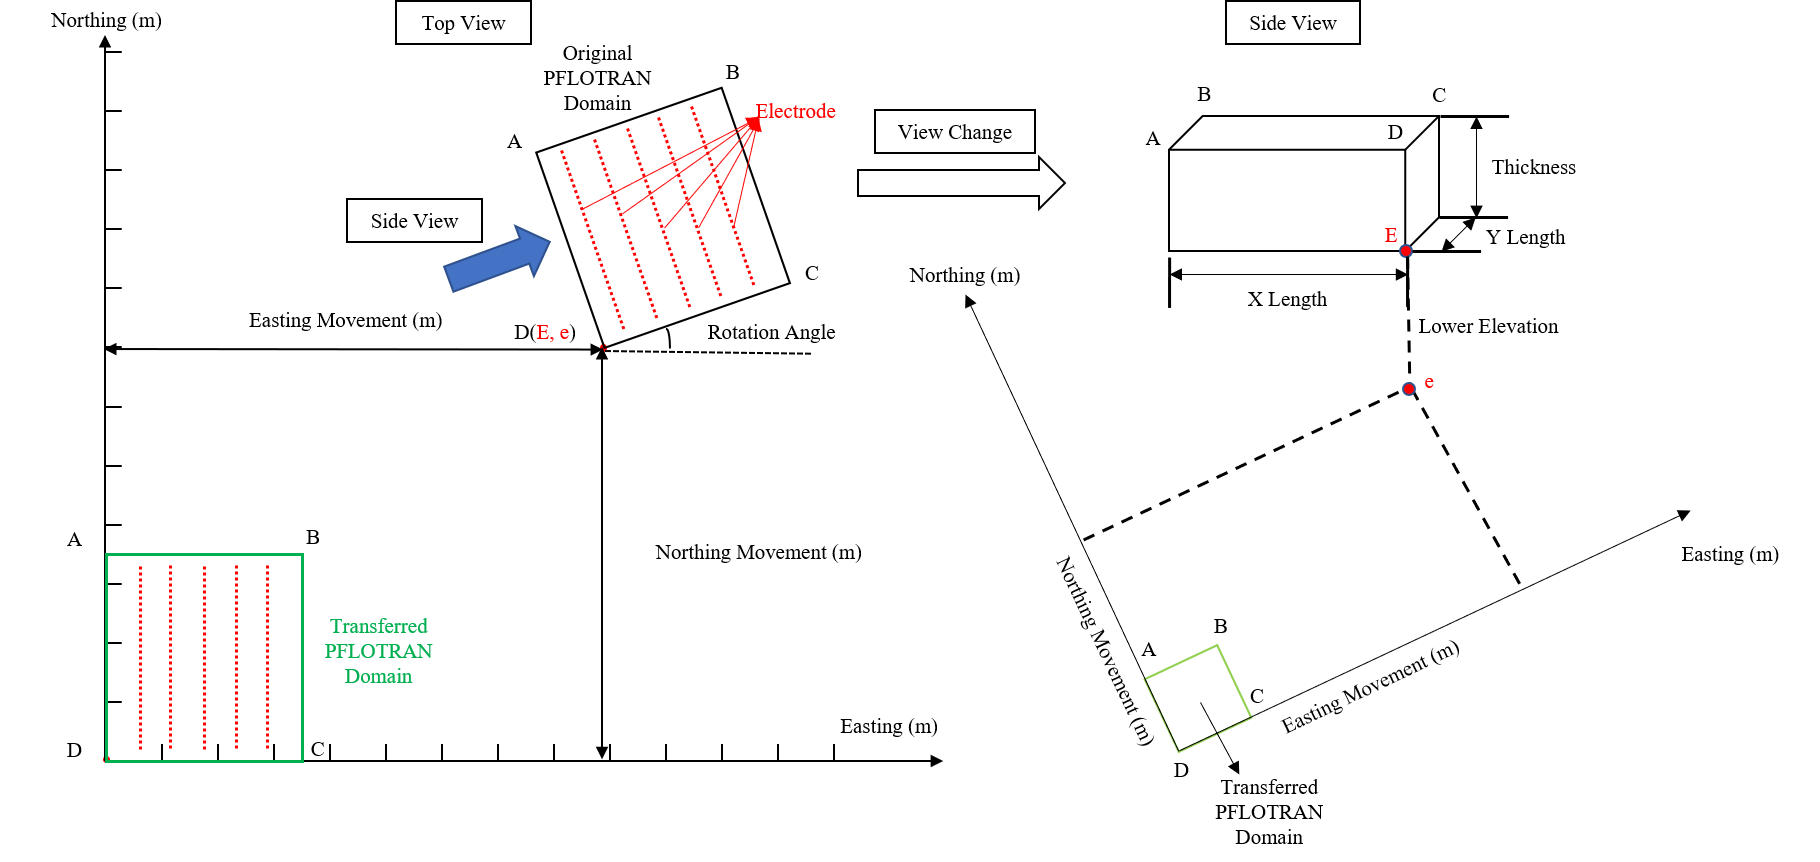

In [8]:
from IPython.display import Image
# from IPython.core.display import HTML 
Image(filename = 'Notebook_Picture/' + 'pf_domain_trans.png', width=1500, height=1500)

First, list the parameters of PFLOTRAN Domain should be included and how these parameters can be used. Also, the example values will be used as default.<br>
The plot above can help you understand what these parameters mean:<br>

1. Base point coordinate and rotation angle:<br>
   The PFLOTRAN Domain uses the **relative coordinate system** and the electrode point location from the survey files are **absolute coordinate system**.<br> 
   For the electrode measurement simulation, we need to transfer the electode location from absolute coordinate system to relatvie coordinate system:<br>
   (1) **Easting Movement (m) -- 594186 m**;<br>
   (2) **Northing Movement (m) -- 115943 m**;<br>
   (3) **Lower Elevation (m) -- 90 m**;<br>
   (4) **Rotation Angle (degree) -- 15**.<br>
   Tips: From the diagram below, the **coordinate of Point E** is **(Easting Movement, Northing Movement, Lower Elevation)**. The **projection of Point E** on **Easting-Northing Plane** is **e**, and its coordinate should be **(Easting Movement, Northing Movement, 0)**. <br>
   See the equation below for the **electrode location transfer**: 
   $$X_{new} = (X_{original}- \Delta X) \times cos(\alpha) + (Y_{original}- \Delta Y) \times sin(\alpha)$$
    $$Y_{new} = (Y_{original}- \Delta Y) \times cos(\alpha) - (X_{original}- \Delta X) \times sin(\alpha)$$
    Where,<br> 
    $X_{new}$ and $Y_{new}$ are the absolute coordinates of electrode;<br> 
    $X_{original}$ and $X_{original}$ are the relative coordinates of electrode;<br>
    $\Delta X$ and $\Delta Y$ are Easting Movement and Northing Movement;<br>
    $\alpha$ is the rotation angle.<br>
    **Z coordinate is not transferred because when the mesh is generated, E4D will transfer it.**
   
2. PFLOTRAN Mesh and E4D Mesh Coupling requires the size of PFLOTRAN Domain:<br>
   (1) **X Length: The length of AD (m) -- 400 m**;<br>
   (2) **Y Length: The length of CD (m) -- 400 m**;<br>
   (3) **Thickness: The length of DE (m) -- 18 m**.<br>

In [9]:
# First, Base point coordinate and rotation angle:
# Moving distance in Easting (m)

print('Please Input the PFLOTRAN Domain Transition Parameters: ')

# Moving distance in Easting (m)
move_E_m_input = widgets.FloatText(value=594186,description='Easting Movement (m):',disabled=False,style=style)

# Moving distance in Northing (m)
move_N_m_input = widgets.FloatText(value=115943,description='Northing Movement (m):',disabled=False,style=style)

# Rotation angle (degree)
rotate_degree_input = widgets.FloatText(value=15,min=0,max=180,description='Rotation Angle (degree):',disabled=False,style=style)

# Lower Boundary Elevation (m)
domain_l_m_input = widgets.FloatText(value=90,description='Lower Elevation (m):',disabled=False,style=style)

display(move_E_m_input, move_N_m_input, rotate_degree_input, domain_l_m_input)

Please Input the PFLOTRAN Domain Transition Parameters: 


FloatText(value=594186.0, description='Easting Movement (m):', style=DescriptionStyle(description_width='150px…

FloatText(value=115943.0, description='Northing Movement (m):', style=DescriptionStyle(description_width='150p…

FloatText(value=15.0, description='Rotation Angle (degree):', style=DescriptionStyle(description_width='150px'…

FloatText(value=90.0, description='Lower Elevation (m):', style=DescriptionStyle(description_width='150px'))

In [10]:
print('Please Input the Size of PFLOTRAN Domain: ')

# Domain Size in X Coordinate (after transition) (m)
domain_x_input = widgets.FloatText(value=400,description='X Length (m):',disabled=False,style=style)

# Domain Size in Y Coordinate (after transition) (m)
domain_y_input = widgets.FloatText(value=400,description='Y Length (m):',disabled=False,style=style)

# Domain Thickness (m)
thickness_input = widgets.FloatText(value=20,description='Thickness (m):',disabled=False,style=style)

display(domain_x_input, domain_y_input, thickness_input)

Please Input the Size of PFLOTRAN Domain: 


FloatText(value=400.0, description='X Length (m):', style=DescriptionStyle(description_width='150px'))

FloatText(value=400.0, description='Y Length (m):', style=DescriptionStyle(description_width='150px'))

FloatText(value=20.0, description='Thickness (m):', style=DescriptionStyle(description_width='150px'))

<font color = red>Tips: Because the **PFLOTRAN Domain** must be **beneath the surface** and it is better to set at least one individual zones for the domain, for sound refinement on Z direction, the **top surface** of the domain should not be too close with the surface. For my case, the **Lower Elevation** is **90 m** and the **Z coordinate of the lowest surface electrode** is about **110-111 m**. The thickness here should be **less than 18 m**. And the **top surface** would be **less than 108 m**, which **leaves at least 2 m for Z-direction refinement**.<font>

In [11]:
# Read the input values
move_E_m = move_E_m_input.value
move_N_m = move_N_m_input.value
rotate_degree = rotate_degree_input.value
domain_l_m = domain_l_m_input.value
domain_u_m = domain_l_m + thickness_input.value
domain_x = domain_x_input.value
domain_y = domain_y_input.value

## 2.2 Relative Coordinate Electrode Location Calculation

Plot the **absolute coordinate** of **electrode points**. If you need to construct E4D Configuration file, survery file is necessary. So, first, check if survery file is available or not and select one.

The survey file you select is:  10015200.srv


Text(0, 0.5, 'Northing')

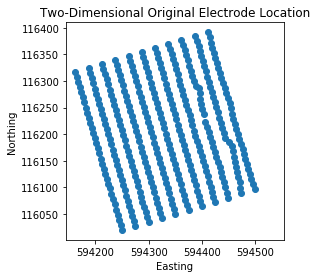

In [12]:
# Show the survery file name to make sure select the right one.
srv_file_name = srv_options.value
print('The survey file you select is: ', '\x1b[0;30;42m' + srv_file_name + '\x1b[0m')

# Read the survery file line by line
elec_loc = open(srv_file_name)
srv_line = elec_loc.readlines()

# The electrode number
elec_NO = int(srv_line[0]) 

# Construct Matrix to store the electrodes No., X, Y, Z, and flag.
elec_ori_info = np.ndarray(shape = (elec_NO, 5), dtype = float) 

for i in range(elec_NO):
    elec = srv_line[i+1].split()
    elec_ori_info[i, 0] = float(elec[0]) # Electrode No.
    elec_ori_info[i, 1] = float(elec[1]) # X
    elec_ori_info[i, 2] = float(elec[2]) # Y
    elec_ori_info[i, 3] = float(elec[3]) # Z
    elec_ori_info[i, 4] = float(elec[4]) # Control point flag
    
# Plot
plt.scatter(elec_ori_info[:,1], elec_ori_info[:,2])
plt.title("Two-Dimensional Original Electrode Location")
plt.axis('square')
plt.xlabel("Easting")
plt.ylabel("Northing")

The vertical elevation is from  90.0 to 110.0  and black rectangle is the mesh domain.


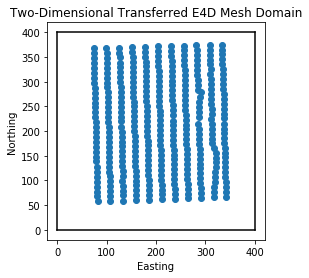

In [13]:
# Construct the relative coordinate matrix
elec_trans_info = np.ndarray(shape = (elec_NO, 5), dtype = float)

# First column is the electorde NO, so keep the same
elec_trans_info[:,0] = elec_ori_info[:,0]
# Second column is the new X coordinate. Transfer the degree to radians first
rotate_radians = math.radians(rotate_degree)
elec_trans_info[:,1] = (elec_ori_info[:,1]-move_E_m) * math.cos(rotate_radians) + (elec_ori_info[:,2]-move_N_m) * math.sin(rotate_radians)
# Third column is the new Y coordinate.
elec_trans_info[:,2] = (elec_ori_info[:,2]-move_N_m) * math.cos(rotate_radians) - (elec_ori_info[:,1]-move_E_m) * math.sin(rotate_radians)
# Fourth Column is the Z coordinate, so keep the same.
elec_trans_info[:,3] = elec_ori_info[:,3]
# Fifth column is the flag, so keep the same.
elec_trans_info[:,4] = elec_ori_info[:,4]

# Plot the 2D of the relative coordinate of electrode points.
plt.scatter(elec_trans_info[:,1], elec_trans_info[:,2])

# The Domain boundary points.
x1, y1 = [0, 400], [400, 400]
x2, y2 = [400, 400], [0, 400]
x3, y3 = [0, 0], [0, 400]
x4, y4 = [0, 400], [0, 0]
plt.plot(x1, y1,'k', x2, y2,'k',x3,y3,'k',x4,y4,'k')

plt.title("Two-Dimensional Transferred E4D Mesh Domain")
plt.axis('square')
plt.xlabel("Easting")
plt.ylabel("Northing")

print('The vertical elevation is from ','\x1b[0;30;42m'+str(domain_l_m)+'\x1b[0m','to','\x1b[0;30;42m'+str(domain_u_m)+'\x1b[0m',' and black rectangle is the mesh domain.')

<font color = red>As a rule of thumb, the **electrode point lines in relative coordinate system** should be **approximately parallel** with the **coordinate system**. Please evaluate your transfer result is acceptable or not.<font>

In [14]:
elec_loc = open(srv_file_name)
srv_line = elec_loc.readlines()

elec_NO = int(srv_line[0]) 
f_ref_lines_l = len(srv_line)

f = open('E4D_comp.srv','w+')
f.write(str(elec_NO))
f.write('\n')

for i in range (elec_NO):
    f.write(str(i+1))
    f.write(" ")
    f.write(str(round(elec_trans_info[i,1])))
    f.write(" ")
    f.write(str(round(elec_trans_info[i,2])))
    f.write(" ")
    f.write(str(elec_trans_info[i,3]))
    f.write(" ")
    f.write('1')
    f.write("\n")
    
for i in range (f_ref_lines_l - elec_NO-1):
    f.write(srv_line[i+elec_NO+1])

elec_loc.close()
f.close()

print('Computational survey file: ','\x1b[0;30;42m'+'E4D_comp.srv'+'\x1b[0m')

Computational survey file:  E4D_comp.srv


## 2.3 E4D Configuration File Construction

This step will generate **E4D configuration file**, with the name **prefix.cfg**. 'prefix' is input by the user in section 2.1.<br>
For more details about how to construct the E4D configuration file, please check the **E4D documentation -- Mode 1**: https://e4d.pnnl.gov/Pages/Documentation.aspx<br>

In [15]:
# Show what the prefix is.
print('The prefix input is: ','\x1b[0;30;42m' + prefix + '\x1b[0m')

f = open(cfg_file_name,"w+")
f.close()

print('\x1b[0;30;42m' + cfg_file_name + '\x1b[0m', 'has been created')

The prefix input is:  E4D_1
E4D_1.cfg has been created


The E4D configuration files contains all the information to generate E4D mesh files, including:
1. **General Block**
2. **Control Points Block**
3. **Internal Boundary Configuration Block**
4. **Hole Configuration Block**
5. **Zone Configuration Block**
6. **Visulization Options Block**<br>

All the parameters will be either **input by user** or **set by default** from section 2.3.1 to 2.3.6.

### 2.3.1 General Block

Variable|Type|Description|Variable in Commands
:------:|:--:|:---------:|:-----------:
m_qual|Real number|The maximum radius-to-edge ratio of any element in the mesh (1.3 - 1.5 Recommended)|mesh_quality_value
max_evol_def|Real number|Default maximum volume of all elements in the mesh|max_vol_value
m_bot|Real number|Elevation of the bottom of the computational mesh|B_bot
tet_build_flag|0 or 1|"0" means E4D buils .poly input file, but will not call tetgen to build mesh;<br>"1" means E4D buils .poly input file, and will call tetgen to build mesh|build_flag
tet_loc|String|The location of the tetgen executable|Tet_loc
tri_loc|String|The location of the triangle executable|Tri_loc

In [16]:
# The first line of E4D Configuration file: Mesh Quality and Max. volume of elements.

# 1-1: Mesh quality: 1.3-1.5 recommended and the less, the better. Default value: 1.3.
mesh_quality_value_input = widgets.FloatText(value=1.3,description='Mesh Quality:',disabled=False,style=style)

# 1-2: Max volume of mesh: the volume of mesh increase with the increase of distance between the element and the control point. 
# Restrict the maximimum volume in the mesh system by setting this value. '1e9' is set by default, and unit is cubic meter.
max_vol_value_input = widgets.FloatText(value= 1e9,description='Max. Element Volume:',disabled=False,style=style)

# The second line of E4D Configuration files: bottom elevation the E4D Mesh Boundary. 
# Simply understanding, users need to set a very deep depth here. '-5000' is set by default. and unit is 'm'
B_bottom_input = widgets.FloatText(value= -5000,description='Boundary Bottom Elevation:',disabled=False,style=style)

# Third line of E4D configuration file: 
# flag whether you want to generate E4D mesh or just surface file with extension '.poly'. The simulation process needs 
# the E4D mesh files, so '1' is set by default and can't be changed.
build_flag_input = widgets.Text(value= "1",description='Mesh Generation Flag:',disabled=True,style=style)

# Fourth line of E4D configuration file:
# E4D need to call a third-party software -- 'tetgen' to generate 3D Delaunay Triangulator. Users need to provide the path
# of executable 'tetgen'. Set the path on NERSC/Project as default path.
Tet_loc_input = widgets.Text(value= '"/global/project/projectdirs/m1800/E4D_20190818/e4d_dev/bin/tetgen"',description='Tetgen Location:',disabled=False,style=style)

# Fifth line of E4D configuration file:
# E4D need to call a third-party software -- 'triangle' to generate 3D Delaunay Triangulator. Users need to provide 
# the path of executable 'triangle'. Set the path on NERSC/Project as default path.
Tri_loc_input = widgets.Text(value= '"/global/project/projectdirs/m1800/E4D_20190818/e4d_dev/bin/triangle"',description='Tetgen Location:',disabled=False,style=style)

display(mesh_quality_value_input,max_vol_value_input,B_bottom_input,build_flag_input,Tet_loc_input,Tri_loc_input)

FloatText(value=1.3, description='Mesh Quality:', style=DescriptionStyle(description_width='150px'))

FloatText(value=1000000000.0, description='Max. Element Volume:', style=DescriptionStyle(description_width='15…

FloatText(value=-5000.0, description='Boundary Bottom Elevation:', style=DescriptionStyle(description_width='1…

Text(value='1', description='Mesh Generation Flag:', disabled=True, style=DescriptionStyle(description_width='…

Text(value='"/global/project/projectdirs/m1800/E4D_20190818/e4d_dev/bin/tetgen"', description='Tetgen Location…

Text(value='"/global/project/projectdirs/m1800/E4D_20190818/e4d_dev/bin/triangle"', description='Tetgen Locati…

In [17]:
# Read Users' inputs
mesh_quality_value = str(mesh_quality_value_input.value)
max_vol_value = str(max_vol_value_input.value)
B_bot = str(B_bottom_input.value)
build_flag = build_flag_input.value
Tet_loc = Tet_loc_input.value
Tri_loc = Tri_loc_input.value

line_general = mesh_quality_value+" "+max_vol_value+'\n'+B_bot+'\n'+build_flag+'\n'+Tet_loc+'\n'+Tri_loc

### 2.3.2 Control Point Block 

There are three types of control points in E4D mesh configuration file:
1. **Mesh Boundary points on Surface** to define the mesh boundary are given **'2'**;
2. **Surface points** to specify known elevation and surface electrode locations on the mesh are given **'1'**;
3. **Internal points** to define the boundary of the E4D domain are given **'0'**;
The values would be calculated using input-values in section 2.2.<br>

Variable|Type|Description
:------:|:--:|:---------:
n_cpts|Postive integer|Specifies the total number of control points
cp_num|Postive integer|The index of the control points specified on this line
x  y  z|Real valued number|The easting, northing, and elevation position of control point <font color='red'>cp_num</font> respectively
b_flag|Integer|Provides the boundary flag for the control point specified on this line:<br> 1. flag = 1, surface control point;<br> 2. flag = 2, external boundary control point;<br> 3. flag = 0, internal control point.<br>

<font color = red> Tips: The order of writing control points are shown below. Write the control points you need.<br>
    1. **Mesh boundary points**, whose flag is **'2'**;<br>
    2. **Zone boundary points (surface)**, whose flag is **'1'**;<br>
    3. **Zone boundary points (internal)**, whose flag is **'0'**;<br>
    4. **Electrode points** whose flag is **'1'** if on surface or **'0'** if internal. The surface electrode points can also **define the surface tomography**.<br><font>
    
See an example below:
    # Mesh boundary points
    1 -5000  5000 115 2
    2 -5000  5000 115 2
    3  5000  5000 115 2
    4  5000 -5000 115 2
    
    # Zone boundary points(The whole domian is beneath the surface, so no surface zone points, only internal zone points need to be set)
    5   0   0 108 0
    6   0 400 108 0
    7 400 400 108 0
    8 400   0 108 0
    
    # Surface electrode points
    9  100 100 114 1
    10 200 200 116 1
    ...

<font color = red> Tips: There is an assumption about the zones setting in this notebook. Please see the plot below. There are **5** default:<br>
    1. Zone 1: From **Boundary Surface Top** to **Domain Top**, for example, from 114 m or surface electrode Z coordinate to 108 m;<br>
    2. Zone 2: From **Domain Top** to **Highest GW Level**, for example, from 108 m to 106.71 m;<br>
    3. Zone 3: From **Highest GW Level** to **Lowest GW Level**, for example, from 106.71 m to 104.73 m;<br>
    4. Zone 4: From **Lowest GW Level** to **Domain Bottom**, for example, from 104.73 m to 90 m;<br>
    5. Zone 5: The rest of whole mesh. Not shown in the plot below.<br>
Limitation: The PFLOTRAN Domain is always considered as beneath the surface, so there is always:
    **<center>Mesh Boundary Top > Domain Top >= Highest GW Level > Lowest GW Level >= Domain Bottom<center>** <br>
Also, consider some possible cases, if **Domain Top - Highest GW Level < 0.1 m**, then **Zone 1** disappear. If **Lowest GW Level - Domain Bottom < 0.1 m**, then **Zone 3** disappear. <font>

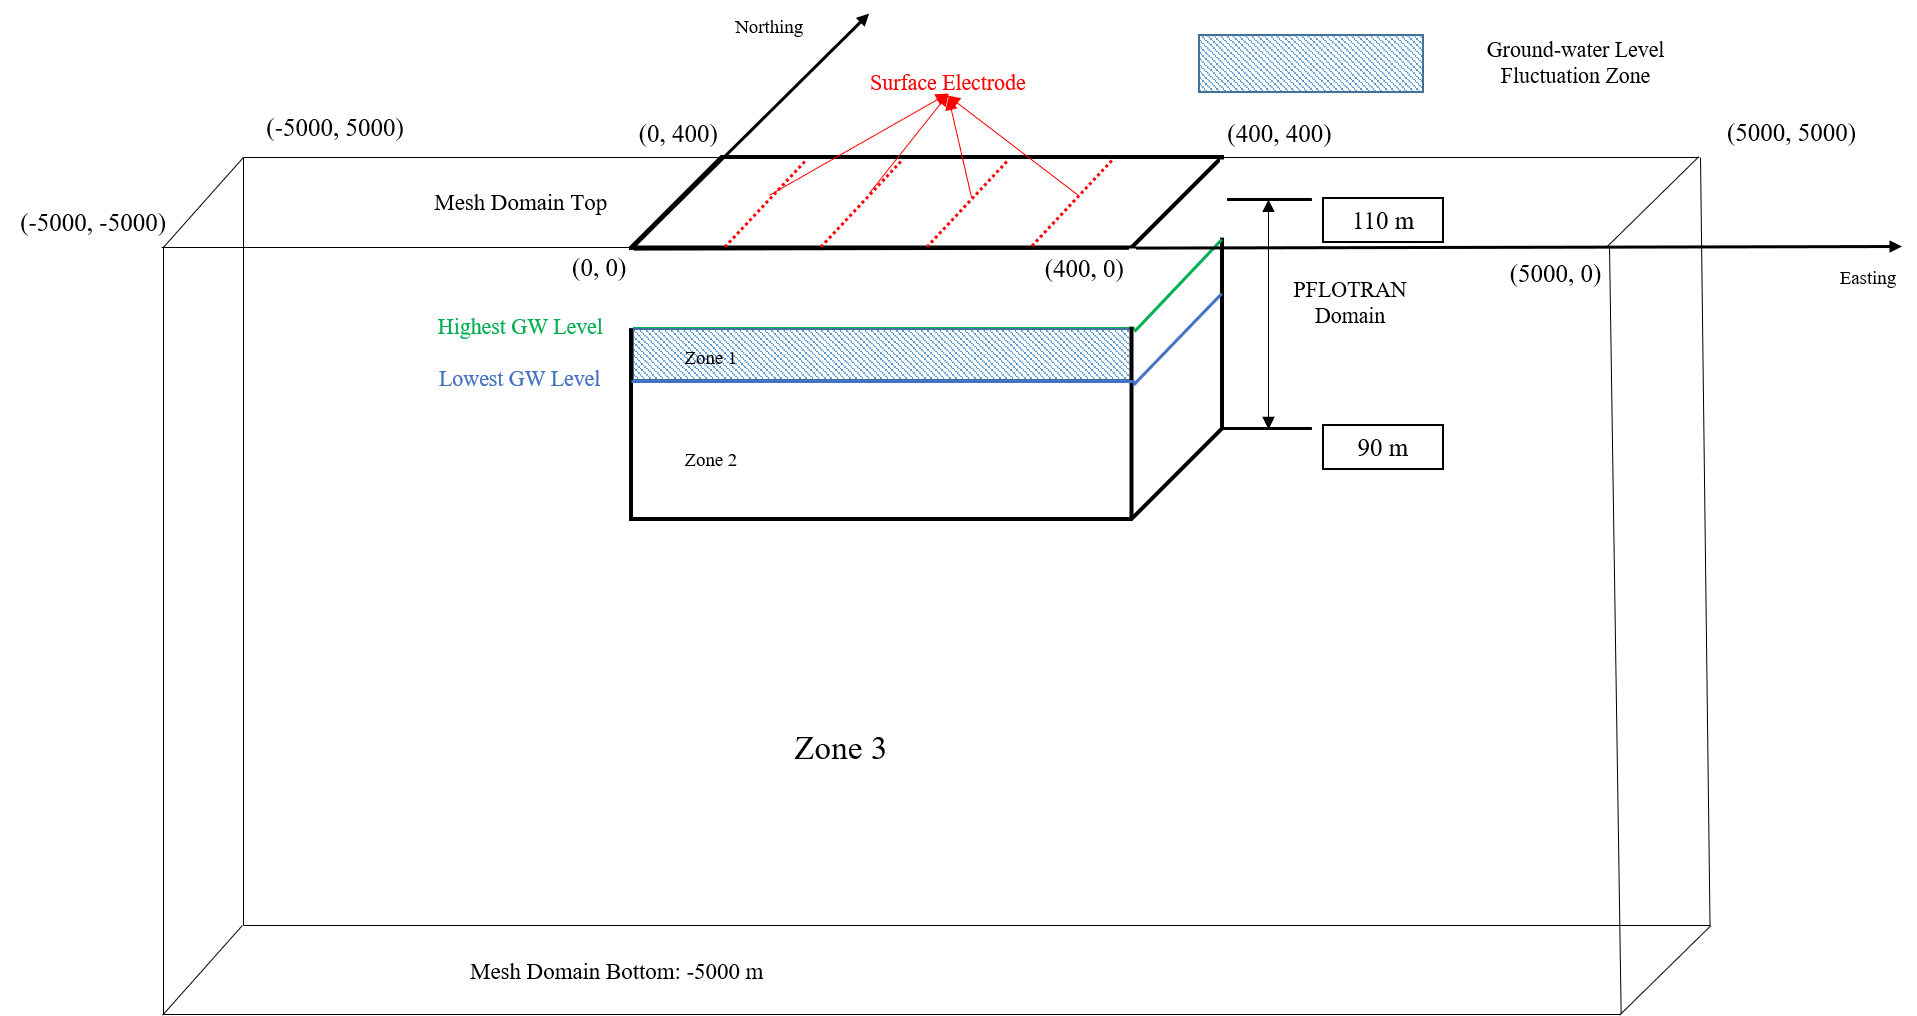

In [18]:
from IPython.display import Image
# from IPython.core.display import HTML 
Image(filename = 'Notebook_Picture/' + 'over_all_zone_no_top_zone.png', width=1000, height=1000)

In [19]:
# Input some control point information.

# Show the top elevation of the Mesh Boundary. The real data is (0,0,118.8), (0,400,116), (400,400,109),(400,400,109), unit is 'm'.
B_top_input_lb = widgets.FloatText(value= 118.8,description='Bound. Top at (0,0):',disabled=False,style=style)
B_top_input_lu = widgets.FloatText(value= 116.0,description='Bound. Top at (0,400):',disabled=False,style=style)
B_top_input_rb = widgets.FloatText(value= 109.0,description='Bound. Top at (400,400):',disabled=False,style=style)
B_top_input_ru = widgets.FloatText(value= 109.0,description='Bound. Top at (400,0):',disabled=False,style=style)

# Show the top elevation of the PFLOTRAN Domain. Unit is 'm'.
domain_l_m_input = widgets.FloatText(value = domain_l_m,description='Domain Bottom Elevation:',disabled=True,style=style)

# Input the highest and lowest groundwater level
gw_h_input = widgets.BoundedFloatText(value= 106.71,min=domain_l_m,max=domain_u_m,description='Highest GW Level:',disabled=False,style=style)
gw_l_input = widgets.BoundedFloatText(value= 104.73,min=domain_l_m,max=domain_u_m,description='Lowest GW Level:',disabled=False,style=style)

display(B_top_input_lb,B_top_input_lu,B_top_input_rb,B_top_input_ru,domain_l_m_input,gw_h_input,gw_l_input)

FloatText(value=118.8, description='Bound. Top at (0,0):', style=DescriptionStyle(description_width='150px'))

FloatText(value=116.0, description='Bound. Top at (0,400):', style=DescriptionStyle(description_width='150px')…

FloatText(value=109.0, description='Bound. Top at (400,400):', style=DescriptionStyle(description_width='150px…

FloatText(value=109.0, description='Bound. Top at (400,0):', style=DescriptionStyle(description_width='150px')…

FloatText(value=90.0, description='Domain Bottom Elevation:', disabled=True, style=DescriptionStyle(descriptio…

BoundedFloatText(value=106.71, description='Highest GW Level:', max=110.0, min=90.0, style=DescriptionStyle(de…

BoundedFloatText(value=104.73, description='Lowest GW Level:', max=110.0, min=90.0, style=DescriptionStyle(des…

In [20]:
# Read GW Level data
gw_h = gw_h_input.value
gw_l = gw_l_input.value

# Check Lowest < Highest or not
if gw_l >= gw_h:
    print('\x1b[0;30;41m' + 'Error: Your input lowest GroundWater Level is higher than highest GroundWater Level. Please re-input.' + '\x1b[0m')
   
# zone number we should set
zone_num = 3
depth = [gw_h,gw_l,domain_l_m]
variable_bot_flag = 1

# More than 10 cm as an individual zone 
if (gw_l-domain_l_m) <= 0.1:
    print('PFLOTRAN Domain Bottom is very close to Lowest GW Level.','\x1b[0;30;41m'+'Zone 2'+'\x1b[0m', 'in above plot disappears.')
    zone_num = zone_num -1
    depth = [gw_h,domain_l_m]
    variable_bot_flag = 0
    
if zone_num == 2:
    depth = [gw_h,domain_l_m]
    
print('\x1b[0;30;42m'+str(zone_num)+'\x1b[0m','zones are in the model according to the values you input.')

3 zones are in the model according to the values you input.


In [21]:
# Construct the control point from here, first, we need to define mesh boundary points, would be 4 points with flag '2'.
# Pre-define a null matrix to avoid repeated matrix stack when you run this cell more than one time without refresh the kernel.
control_point_info = []

B_top_lb = B_top_input_lb.value
B_top_lu = B_top_input_lu.value
B_top_rb = B_top_input_rb.value
B_top_ru = B_top_input_ru.value

# They are the first 4 numbers in the control points definition: 1, 2, 3, 4.
B_west = -5000
B_east = 5000
B_north = 5000
B_south = -5000
Boundary_point_info = np.array([(1,B_west,B_south,B_top_lb,2), (2,B_west,B_north,B_top_lu,2),(3,B_east,B_north,B_top_rb,2),(4,B_east,B_south,B_top_ru,2)])

# Then, the zone points to define the zones. The numbers depending on how many zones we have. zone_points_number = (i+1) * 4, i is the zone_number: 2 or 3. 
# The first 4 points in this parts are with flag of '1' for surface tomography and the others are internal points with flag '0'.
Surface_point_info = [(5,0,0,B_top_lb,1), (6,0,domain_y,B_top_lu,1),(7,domain_x,domain_y,B_top_rb,1),(8,domain_x,0,B_top_ru,1)]
Domain_point_info = [(9,0,0,depth[0],0), (10,0,domain_y,depth[0],0),(11,domain_x,domain_y,depth[0],0),(12,domain_x,0,depth[0],0)]

for i in range(zone_num-1):
    mid_point_number = [(13+i*4,0,0,depth[i+1],0), (14+i*4,0,domain_y,depth[i+1],0),(15+i*4,domain_x,domain_y,depth[i+1],0),(16+i*4,domain_x,0,depth[i+1],0)]
    Domain_point_info = np.vstack((Domain_point_info, mid_point_number))
    
control_point_info = np.vstack((Boundary_point_info,Surface_point_info,Domain_point_info))
Row_length = len(control_point_info)

In [22]:
# Add surface electrode points and auxillary points which is 10 cm below.
# Surface electrode points
elec_info = np.zeros(shape=(elec_NO, 5))
elec_info[:,0] = elec_trans_info[:,0]+Row_length
elec_info[:,1] = elec_trans_info[:,1]
elec_info[:,2] = elec_trans_info[:,2]
elec_info[:,3] = elec_trans_info[:,3]
elec_info[:,4] = elec_trans_info[:,4]

# Auxillary points, 10 cm below.
elec_info_aux = np.zeros(shape=(elec_NO,5))
elec_info_aux[:,0] = elec_trans_info[:,0]+Row_length+elec_NO
elec_info_aux[:,1] = elec_trans_info[:,1]
elec_info_aux[:,2] = elec_trans_info[:,2]
elec_info_aux[:,3] = elec_info[:,3]-0.1
elec_info_aux[:,4] = 0

# Combine the all the control points
control_point_total_info = np.vstack((control_point_info, elec_info, elec_info_aux))
control_point_num = len(control_point_total_info)

print('There are','\x1b[0;30;42m'+str(control_point_num)+'\x1b[0m','control points in the model:')
print('Among them, point','\x1b[0;30;42m'+'1'+'\x1b[0m', 'to point','\x1b[0;30;42m'+'4'+'\x1b[0m','are Mesh Boundary points;')
print('Among them, point','\x1b[0;30;42m'+'5'+'\x1b[0m', 'to point','\x1b[0;30;42m'+'8'+'\x1b[0m','are surface tomography of domain boundary;')
print('Among them, point','\x1b[0;30;42m'+'9'+'\x1b[0m', 'to point','\x1b[0;30;42m'+str(Row_length)+'\x1b[0m','are Zone Definition points;')
print('Among them, point','\x1b[0;30;42m'+str(Row_length+1)+'\x1b[0m', 'to point','\x1b[0;30;42m'+str(Row_length+elec_NO)+'\x1b[0m','are Surface Electrode points;')
print('Among them, point','\x1b[0;30;42m'+str(Row_length+elec_NO+1)+'\x1b[0m', 'to point','\x1b[0;30;42m'+str(Row_length+elec_NO+elec_NO)+'\x1b[0m','are Additional Surface Electrode points for Refinement (0.1m below);')
print('Please make basic evaluation and check them in the E4D Configuration file if you want.')

There are 724 control points in the model:
Among them, point 1 to point 4 are Mesh Boundary points;
Among them, point 5 to point 8 are surface tomography of domain boundary;
Among them, point 9 to point 20 are Zone Definition points;
Among them, point 21 to point 372 are Surface Electrode points;
Among them, point 373 to point 724 are Additional Surface Electrode points for Refinement (0.1m below);
Please make basic evaluation and check them in the E4D Configuration file if you want.


### 2.3.3 Internal Boundary Configuration Block

Internal boundaries consist of user-defined internal planes (piecewise linear complexes in the tetgen tutorials) that seperate one region of the mesh from another. Internal boundaries that close to form a 'watertight' structure form a zone within the mesh. Boundaries are specified by describing how selected control points are connected to form planes.<br>

Variable|Type|Description
:------:|:--:|:---------:
n_plc|Non-negative integer|Total number of user-defined internal planes
np|Integer|Number of control points used to define this plane.
b_num|Integer|Specifies the boundary number for the plane. The integer can be any value except 0, 1, or 2.
p1 p2 ... p_np|Non-negative integer|p* is the *th control point defining this plane

In [23]:
# The internal planes would be (zone_num-1)*5
# Pre-define a null matrix to avoid repeated matrix stack when you run this cell more than one time without refresh the kernel.
plc_info = np.array([(9,10,14,13),(10,11,15,14),(11,12,16,15),(12,9,13,16),(9,10,11,12),(13,14,15,16)])
plc_NO = (zone_num-1)*5+1

for i in range(zone_num-2):
    mid_plc = np.array([(9+(i+1)*4,10+(i+1)*4,14+(i+1)*4,13+(i+1)*4),(10+(i+1)*4,11+(i+1)*4,15+(i+1)*4,14+(i+1)*4),(11+(i+1)*4,12+(i+1)*4,16+(i+1)*4,15+(i+1)*4),
                        (12+(i+1)*4,9+(i+1)*4,13+(i+1)*4,16+(i+1)*4),(13+(i+1)*4,14+(i+1)*4,15+(i+1)*4,16+(i+1)*4)])
    plc_info = np.vstack((plc_info,mid_plc))
    
print('There are','\x1b[0;30;42m'+str(plc_NO)+'\x1b[0m','internal planes in the model.')

There are 11 internal planes in the model.


### 2.3.4 Hole Configuration Block

Any zone defined within E4D can be turned into a hole or void in the mesh. To create a hole, tetgen begins at one point within the subject zone and successively removes all of the elements enclosed within the zone boundary.<br>

Variable|Type|Description
:------:|:--:|:---------:
n_holes|Non-negative integer|Specifies the number of holes in the mesh
hn|Integer|Index of the hole, ranging from 1 to n_holes
xh yh zh|Real valued number|The easting, northing, and elevation of any point within this hole

In [24]:
# No holes or relevant zones exist for our test case, so set it '0' by default.
hole_NO = 0

### 2.3.5 Zone Configuration Block

The zone configuration block assigns maximum element volumes, conductivity values, and zone numbers to each zone.

Variable|Type|Description
:------:|:--:|:---------:
n_zones|Positive integer|Number of defined zones
zn|Positive integer|Zone number assigned to this zone
xz yz zz|Real valued number|The easting, northing, and elevation of any point within this zone
mz_vol|Positive valued number|The maximum volume of any point elements within this zone
zcond|Positive valued number|The conductivity of this zone

In [25]:
# Input the conductivity for rock conductivity. 
# Add formation lithology here.
rock_cond_input = widgets.FloatText(value= 0.001,description='Rock Conductivity (S/m): ',disabled=False,style=style)

display(rock_cond_input)

FloatText(value=0.001, description='Rock Conductivity (S/m): ', style=DescriptionStyle(description_width='150p…

In [26]:
# Read the input conductivity
rock_cond = rock_cond_input.value

# Construct the max volume matrix
if zone_num == 3:
    max_vol_matrix = [10,50,max_vol_value]
    print('The GW Level Fluctuation zone is', '\x1b[0;30;42m'+'zone 1'+'\x1b[0m','in the E4D Configuration file')

if zone_num == 2:
    max_vol_matrix = [10,max_vol_value]
    print('Zone 2 in above plot disappear. The GW Fluctuation Zone is', '\x1b[0;30;42m'+'zone 1'+'\x1b[0m', 'in the E4D Configuration file.')
        

# Construct matrix to store point position inside the zones.
mid_point_z = np.zeros(zone_num)

# Use the center of electrode points as the X, Y Coordinate of the points inside every zone.
mid_point_X = int((np.min(elec_info[:,1]) + np.max(elec_info[:,1]))/2)
mid_point_Y = int((np.min(elec_info[:,2]) + np.max(elec_info[:,2]))/2)

# Z coordinate of the points inside every zone is computed by average of its top and bottom elevation.
for i in range(zone_num-1):
    mid_point_z[i] = int((depth[i]+depth[i+1])/2)
    
zone_info = np.array([(1,mid_point_X,mid_point_Y,mid_point_z[0],max_vol_matrix[0],rock_cond)])
for i in range(zone_num-2):
    new_zone = np.array([((i+2),mid_point_X,mid_point_Y,mid_point_z[i+1],max_vol_matrix[i+1],rock_cond)])
    zone_info = np.vstack((zone_info,new_zone))
    
boundary_z = (depth[zone_num-1]+B_bottom_input.value)/2
boundary_zone = np.array([(zone_num,mid_point_X,mid_point_Y,boundary_z,max_vol_matrix[zone_num-1],rock_cond)])
zone_info = np.vstack((zone_info,boundary_zone))

The GW Level Fluctuation zone is zone 1 in the E4D Configuration file


### 2.3.6 Visulization Options Block

The visualization options block provides the option to automatically produce an exodus file for visualization once the mesh is generated.<br>

Variable|Type|Description
:------:|:--:|:---------:
bx_flag|Integer|0: E4D builds exodus for mesh visualization; <br> 1: E4D doesn't build exodus for mesh visualization.
bx_loc|String|location of the utility program "bx"
mtr_opt|Integer|0: Mesh translation not applied; <br> 1: Mesh translation applied

In [27]:
# Flag if users want to generate a file for E4D mesh visulization. Set '1' by default.
bx_flag_input = widgets.Text(value= "1",description='Mesh Generation Flag:',disabled=True,style=style)

# Provide the path of excutable 'bx'.
bx_loc_input = widgets.Text(value= '"/global/project/projectdirs/m1800/E4D_20190818/e4d_dev/bin/bx"',description='bx path',disabled=False,style=style)

# Flag if users want to translate the E4D mesh or not. E4D will translate your mesh from original position to (0,0) to
# generate mesh and record the movement in '.trn' file. For coupling, set '0' by default. But actually, because we build 
# the mesh domain from (0,0), so '0' or '1' makes no difference for the test case.
mtr_opt_input = widgets.Text(value= "0",description='Translation Option:',disabled=True,style=style)

display(bx_flag_input,bx_loc_input,mtr_opt_input)

Text(value='1', description='Mesh Generation Flag:', disabled=True, style=DescriptionStyle(description_width='…

Text(value='"/global/project/projectdirs/m1800/E4D_20190818/e4d_dev/bin/bx"', description='bx path', style=Des…

Text(value='0', description='Translation Option:', disabled=True, style=DescriptionStyle(description_width='15…

In [28]:
bx_flag = bx_flag_input.value
bx_loc = bx_loc_input.value
mtr_opt = mtr_opt_input.value

vis_line = bx_flag + '\n' + bx_loc + '\n' + '\n' + mtr_opt

### 2.3.7 Write into E4D Configuration File

In [29]:
# Currently, some values are input into the script directly. After adding the sub-domains, some parameters should from 
# users' choice.
cfg_file_name = prefix+'.cfg'
f = open(cfg_file_name,'w+')

f.write(line_general)
f.write('\n' + '\n')

f.write(str(control_point_num))
f.write('\n')
for i in range(control_point_num):
    f.write(str(int(control_point_total_info[i,0])))
    f.write(" ")
    f.write(str(round(control_point_total_info[i,1],2)))
    f.write(" ")
    f.write(str(round(control_point_total_info[i,2],2)))
    f.write(" ")
    f.write(str(round(control_point_total_info[i,3],2)))
    f.write(" ")
    f.write(str(int(control_point_total_info[i,4])))
    if i in [3,7]:
        f.write('\n')
                
    if i == Row_length-1:
        f.write('\n' + '\n')
    else:
        f.write('\n')
f.write('\n' + '\n')

f.write(str(plc_NO))
f.write('\n')
for i in range(plc_NO):
    f.write("4" + " " + "10")
    f.write("\n")
    for j in range(4):
        f.write(str(plc_info[i,j]))
        f.write(' ')
    f.write("\n")
f.write('\n')

f.write(str(hole_NO))
f.write('\n' + '\n')

f.write(str(zone_num))
f.write('\n')
for i in range(zone_num):
    f.write(str(zone_info[i,0])[0])
    f.write(' ')
    for j in range(5):
        f.write(str(zone_info[i,j+1]))
        f.write(' ')
    f.write("\n")
f.write('\n')

f.write(vis_line)

f.close()

## 3. Run E4D Mode 1

Notice: Please make sure the configuration is the one for your case. Running the code without any errors does not mean your results are right...

E4D mode 1 is to generate E4D mesh files. This section will write a 'e4d.inp' file including the name of the E4D configuration file and run E4D mode 1.<br>
After the generation, visulize the E4D Mesh.

In [30]:
f = open("e4d.inp", "w+")

f.write('1 \r\n')
f.write(cfg_file_name)

f.close()

In [ ]:
# export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/global/project/projectdirs/m1800/E4D_20190818/e4d_dev/third_party/netcdf/liblib/.libs

In [86]:
# ~/test/petsc/arch-linux-c-opt/bin/mpirun -np 353 ~/test/e4d_dev/bin/e4d


 ************************ WELCOME TO E4D ************************
 Copyright © 2014, Battelle Memorial Institute
 All rights reserved.
 Current date:  September 17, 2019
 Current time:  14:10:44
 Running on 0000001 processing cores
 Please refer to e4d.log for further logging information ...
 ****************************************************************
 Calling Triangle
Opening surface.poly.
Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  0
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
Quality milliseconds:  0

Writing surface.1.node.
Writing surface.1.ele.
Writing surface.1.poly.
Writing surface.1.edge.
Writing surface.1.neigh.

Output milliseconds:  6
Total running milliseconds:  8

Statistics:

  Input vertices: 360
  Input segments: 4
  Input holes: 0

  Mesh vertices: 954
  Mesh triangles: 1891
  Mesh edges: 2844
  Me

libhugetlbfs [cori13:48888]: WARNING: Hugepage size 2097152 unavailablelibhugetlbfs [cori13:48888]: WARNING: New heap segment map at 0x10000000000 failed: Cannot allocate memory
